# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

from sklearn.model_selection import train_test_split

from sklearn import metrics

In [55]:
set_plot_sizes(12,14,16)

In [28]:
import graphviz

In [3]:
df_raw = pd.read_csv('heart.csv', low_memory=False)

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [5]:
display_all(df_raw.tail().T)

,298,299,300,301,302
age,57.0,45.0,68.0,57.0,57.0
sex,0.0,1.0,1.0,1.0,0.0
cp,0.0,3.0,0.0,0.0,1.0
trestbps,140.0,110.0,144.0,130.0,130.0
chol,241.0,264.0,193.0,131.0,236.0
fbs,0.0,0.0,1.0,0.0,0.0
restecg,1.0,1.0,1.0,1.0,0.0
thalach,123.0,132.0,141.0,115.0,174.0
exang,1.0,0.0,0.0,1.0,0.0
oldpeak,0.2,1.2,3.4,1.2,0.0


In [6]:
display_all(df_raw.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [7]:
train_cats(df_raw)

In [ ]:
# df_train, df_Test = train_test_split(df_raw,test_size = 0.25,random_state = 0)

In [10]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

age         0.0
ca          0.0
chol        0.0
cp          0.0
exang       0.0
fbs         0.0
oldpeak     0.0
restecg     0.0
sex         0.0
slope       0.0
target      0.0
thal        0.0
thalach     0.0
trestbps    0.0
dtype: float64

In [11]:
df, y, nas = proc_df(df_raw, 'target')

In [44]:
m = RandomForestClassifier(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

/Users/jbency/anaconda3/envs/fastaitest/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9933993399339934

In [15]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 75  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((228, 13), (228,), (75, 13), (75,))

In [16]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### Train and check score

In [45]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(df, y)
print_score(m)

/Users/jbency/anaconda3/envs/fastaitest/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 16.6 ms, sys: 6.91 ms, total: 23.5 ms
Wall time: 111 ms
[0.13245323570650439, 0.16329931618554522, 0.9824561403508771, 0.9733333333333334]


### Single tree

In [46]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.35664125175887934, 0.7745966692414834, 0.8728070175438597, 0.4]


In [47]:
df_trn, y_trn, nas = proc_df(df_raw, 'target', subset=228, na_dict=nas)

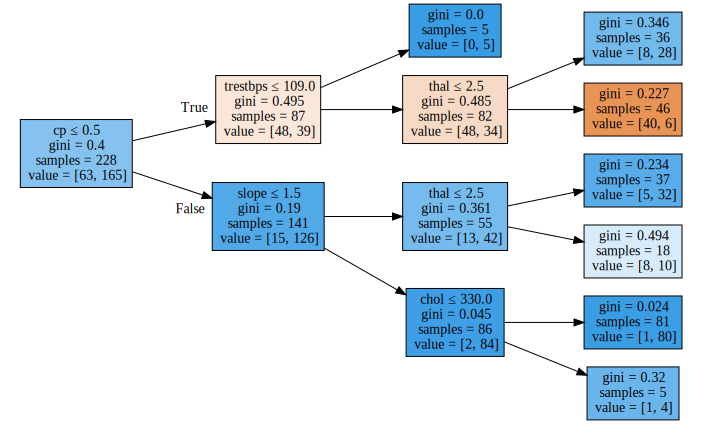

In [48]:
draw_tree(m.estimators_[0], df_trn, precision=3)

### Bagging

In [49]:
# Basic model
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/Users/jbency/anaconda3/envs/fastaitest/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.0936585811581694, 0.6110100926607787, 0.9912280701754386, 0.6266666666666667]


In [51]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11339797563092995, 0.5716186811736182, 0.9356933621933622, 0.0]


In [52]:
m = RandomForestClassifier(n_estimators=60, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11270422226074589, 0.5578065508293607, 0.9364777938111272, 0.0]


### OOB Score

In [53]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12157590943269134, 0.5690562362368063, 0.9260836940836942, 0.0, 0.49397255476274926]


In [98]:

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required.

In [57]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 28.7 ms, sys: 2.2 ms, total: 30.9 ms
Wall time: 29.5 ms


(0.866984126984127, 0.21866476851604114)

In [58]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 34.6 ms, sys: 38.9 ms, total: 73.5 ms
Wall time: 81.7 ms


(0.866984126984127, 0.21866476851604114)

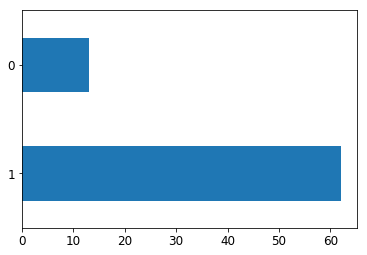

In [64]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.sex.value_counts().plot.barh();

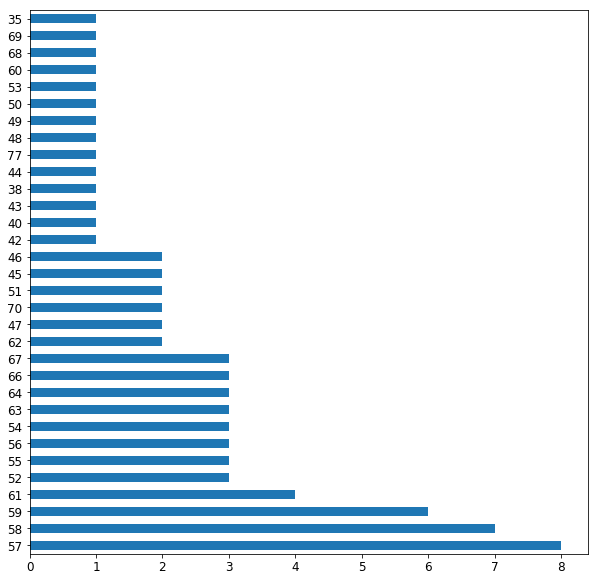

In [75]:
raw_valid.age.value_counts().plot.barh(figsize=(10,10));

In [72]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
12,thal,0.273231
9,oldpeak,0.203910
2,cp,0.142874
11,ca,0.100844
7,thalach,0.068511
8,exang,0.052906
4,chol,0.052810
0,age,0.027213
10,slope,0.023230
3,trestbps,0.022571


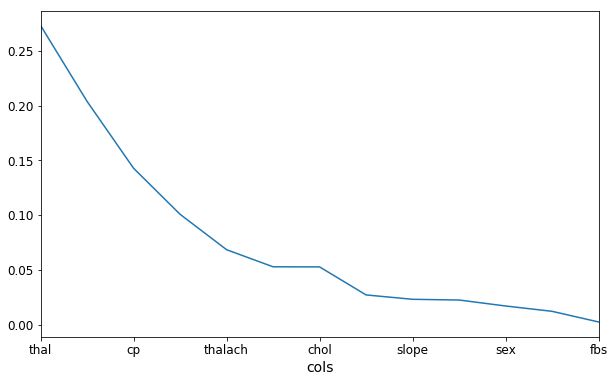

In [73]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [78]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

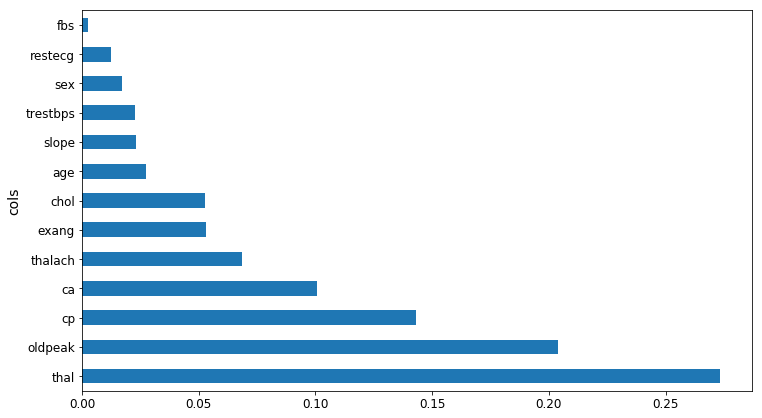

In [81]:
plot_fi(fi);

In [82]:
to_keep = fi[fi.imp>0.05].cols; len(to_keep)

7

In [83]:
to_keep

12       thal
9     oldpeak
2          cp
11         ca
7     thalach
8       exang
4        chol
Name: cols, dtype: object

In [101]:
df_keep = df_raw[to_keep].copy()
df_keep['target'] = df_raw.target
X_train, X_valid = split_vals(df_keep, n_trn)

In [102]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
df, y, nas = proc_df(df_keep, 'target')
n_valid = 75  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_keep, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((228, 7), (228,), (75, 7), (75,))

In [103]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2564945880212885, 0.6928203230275509, 0.9342105263157895, 0.52, 0.8903508771929824]


In [104]:
from scipy.cluster import hierarchy as hc

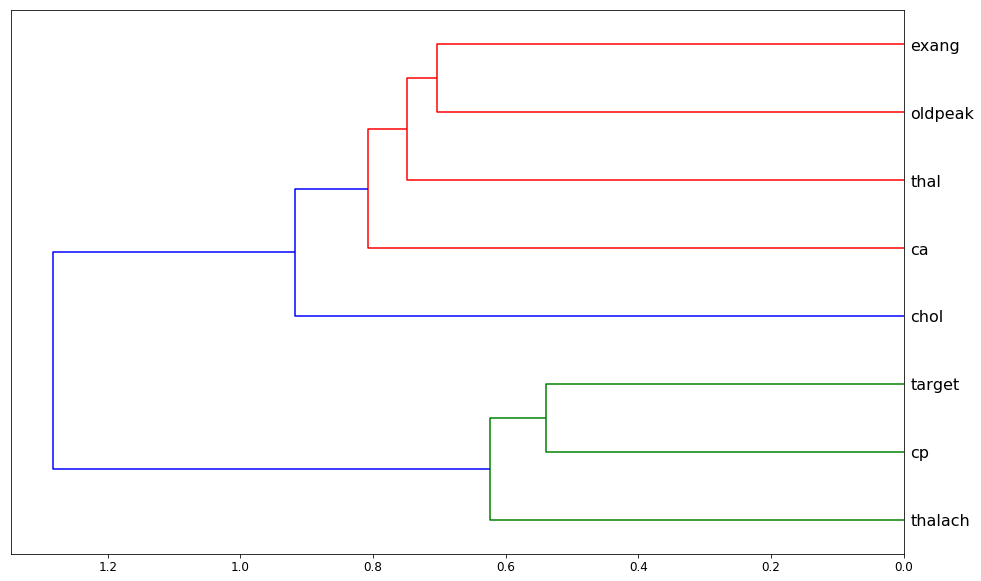

In [105]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [106]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [107]:
get_oob(df_keep)

0.9681333028976288